# Image retrieval, captioning and classification with CoCo

This tutorial uses the [CoCo dataset "Common objects in Context"](https://cocodataset.org/#home) to show case some of the key-features of SuperDuperDB. In this example, you'll learn how to:

- Prepare data in the best way for SuperDuperDB usage
- Define data types
- Upload and query data to and from the data base
- Define multiple models on the database, including models with dependencies
- Define a searchable semantic index based on existing models
- Train a semantic index from scratch

If you haven't downloaded the data already, execute the lines of bash below. We've tried to keep it clean,
and for reasons of efficiency have resized the images using imagemagick.

In [ ]:
!mkdir -o data/coco/
!curl http://images.cocodataset.org/annotations/annotations_trainval2014.zip -o data/coco/raw.zip
!unzip data/coco/raw.zip
!mv data/coco/annotations/captions_train2014.json data/coco/
!rm -rf data/coco/annotations
!rm data/coco/raw.zip
!curl http://images.cocodataset.org/zips/train2014.zip -o data/coco/images.zip
!unzip data/coco/images.zip
!rm data/coco/images.zip
!sudo apt install imagemagick
!mogrify -resize 224x data/coco/images/*.jpg

SuperDuperDB uses MongoDB for data storage. If you haven't done so already, install it using the following lines of bash.

In [ ]:
!wget -qO - https://www.mongodb.org/static/pgp/server-6.0.asc | sudo apt-key add -
!sudo apt-get install gnupg
!wget -qO - https://www.mongodb.org/static/pgp/server-6.0.asc | sudo apt-key add -
!echo "deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu focal/mongodb-org/6.0 multiverse" | sudo tee /etc/apt/sources.list.d/mongodb-org-6.0.list
!sudo apt-get update
!sudo apt-get install -y mongodb-org

In case you haven't done so already, install the dependencies for this tutorial, including SuperDuperDB,
which is a simple pip install.

In [ ]:
!pip install pandas
!pip install pillow
!pip install torch
!pip install superduperdb

SuperDuperDB can handle data in any format, including images. The documents in the database are MongoDB `bson` documents, which mix `json` with raw bytes and `ObjectId` objects. SuperDuperDB takes advantage of this by 
serializing more sophisticated objects to bytes, and reinstantiating the objects in memory, when data is queried.

In order to tell SuperDuperDB what type an object has, one specifies this with a subdocument of the form:

```json
{
    "_content": {
        "bytes": ...,
        "type": "<my-type>",
    }
}
```

If however, the content is located on the web or the filesystem, one can specify the URLs directly:

```json
{
    "_content": {
        "url": "<url-or-file>",
        "type": "<my-type>",
    }
}
```

Let's see this now in action. We reformat the CoCo data, so that each image is associated in one document with all of the captions which describe it, and add the location of the images using the `_content` formalism.

In [ ]:
import json

with open('data/coco/captions_train2014.json') as f:
    raw = json.load(f)
    
raw['images'] = {x['id']: x for x in raw['images']}

for im in raw['images']:
    raw['images'][im]['captions'] = []
    
for a in raw['annotations']:
    raw['images'][a['image_id']]['captions'].append(a['caption'])

raw = list(raw['images'].values())

for i, im in enumerate(raw):
    # if image is already in memory, then add 'bytes': b'...' instead of 'url': '...'
    # for content located on the web, use 'http://' or 'https://' instead of 'file://'
    im['img'] = {
        '_content': {'url': f'file://data/coco/images/{im["file_name"]}', 'type': 'image'}
    }
    raw[i] = {'captions': im['captions'], 'img': im['img']}

with open('data/coco/data.json', 'w') as f:
    json.dump(raw, f)

In [1]:
import json
import sys

sys.path.append('../../')

from superduperdb.client import the_client
from IPython.display import display, clear_output
import torch

docs = the_client.coco_example.documents

We'll load the data and add most of it to the database. We'll hold back some data so that we can see how to update 
the database later.

In [7]:
with open('data/coco/data.json') as f:
    data = json.load(f)
    
docs.insert_many(data[:-1000]), verbose=True)

We previously added the type `image` to the `_content` subrecords earlier.
So that we can load the data using this type, we need to add this type to the database.
You can see in `examples/types.py` how the class encodes and decodes data. Suffice to say at this point, 
that each type has an `encode` and `decode` method, which convert to and from `bytes`.

In [ ]:
from examples.types import FloatTensor, Image

docs.create_type('float_tensor', FloatTensor())
docs.create_type('image', Image())

In the first AI task which we implement for the `docs` collection, we'll be setting up a model to retrieve relevant images using provided text. For this data, that means the `captions` field being used to retrieve the `img` field. In order to be able to keep an objective record of performance, we can set up an immutable validation dataset from the collection. We use a **splitter** to define how we'd like to test retrieval. This splits the documents into query and retrieved document.

In [ ]:
docs.create_validation_set(
    'text2image_retrieval', 
    filter={},
    splitter=lambda x: ({'img': x['img']}, {'captions': [x['captions'][0]]}),
    sample_size=1000,
)

We can see what the data points in the validation set look like by querying:

In [ ]:
docs['_validation_sets'].find_one({'_validation_set': 'text2image_retrieval'})

You can see that the sample "query" is split into the `_other` field. This is important when evaluating semantic indexes.

Now let's start adding a model to the collection.
A nice open source model to test text-2-image retrieval is [CLIP](https://openai.com/blog/clip/) which understands images and texts and embeds these in a common vector space.

Note that we are specifying the type of the model output, so that the collection knows how to store the results, as well as "activating" the model with `active=True`. That means, whenever we add data which fall under the `filter`, then these will get processed by the model, and the outputs will be added to the collection documents.

The `key` argument specifies which part of the document the model should act. If `key="_base"` then the model takes the whole document as input. Since we'll be encoding documents as images, then we'll chose `key="img`.

In [ ]:
from examples.models import CLIP

docs.create_model(
    name='clip',
    object=CLIP('RN50'),
    filter={},
    type='float_tensor',
    key='img',
    verbose=True,
    active=True
)

We'll create a companion model which uses the same underlying object as the previous model. That's specified by adding the name instead of the object in the `object` argument. In this case the model is not `active`, since we'll only be using it for querying the collection. We don't need to specify a `type` since that was done in the last step.

In [ ]:
docs.create_model(
    name='clip_text',
    object='clip',
    key='captions',
    active=False,
)

We'll also create a measure which tests how similar to each other two outputs might be. Since CLIP was trained with cosine-similarity we'll use that here too.

In [ ]:
from examples.measures import css

docs.create_measure('css', css)

In order to be able to measure performance on the validation set, we'll add a **metric**.

In [ ]:
from examples.metrics import PatK

docs.create_metric('p_at_10', PatK(10))

Now we're ready to go to add a **semantic index**. This is a tuple of models, one of which is activated in order to populate the collection with vectors. The idea is that any of the models in the **semantic index** can be used to query the collection using nearest neighbour lookup based on the **measure** chosen.

In [ ]:
from examples.models import CLIP

docs.create_semantic_index(
    'clip',
    models=['clip', 'clip_text'],
    measure='css',
    metrics=['p_at_10'],
)

In [ ]:
from bson import ObjectId
from IPython.display import display

docs.semantic_index = 'clip'
for r in docs.find({'$like': {'document': {'_id': ObjectId('63d27372745cc274ef3518f2')}, 'n': 10}}):
    display(r['img'])

Let's now evaluate the quality of this semantic index

In [16]:
docs.validate_semantic_index('clip', ['text2image_retrieval'], ['p_at_10'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:00<00:00, 27645.76it/s]


loading hashes: "clip"


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [27:54<00:00,  1.67s/it]


In [ ]:
docs['_semantic_indexes'].find_one()

We can see that we can get nice meaningful retrievals using the CLIP model from short descriptive pieces of text.
This is very useful, since the model is now deployed to the database, listening for incoming queries.

In [ ]:
docs.list_semantic_indexes()

In [ ]:
from IPython.display import display

docs.semantic_index = 'clip'
for r in docs.find({'$like': {'document': {'captions': ['Dog catches a frisbee']}, 'n': 5}}):
    display(r['img'])

In the next section of this example, let us train our own model from scratch. The model will be much simpler than the clip model, but will yield faster retrievals. It will be interesting to see how this compares to CLIP, and show-case SuperDuperDB as a framework for easily integrating and benchmarking AI models, in particular for retrieval.

First we will implement a simpler sentence embedding, using a simple word-embedding approach based around Glove.
Please look at the model in `examples.models.AverageOfGloves`.

In [ ]:
!curl https://nlp.stanford.edu/data/glove.6B.zip -o data/glove.6B.zip
!unzip data/glove.6B.zip

We may register this model to the collection in the same way we did for the textual part of CLIP:

In [ ]:
import numpy
import torch
from examples.models import AverageOfGloves

with open('data/glove.6B/glove.6B.50d.txt') as f:
    lines = f.read().split('\n')
    
lines = [x.split(' ') for x in lines[:-1]]
index = [x[0] for x in lines]
vectors = [[float(y) for y in x[1:]] for x in lines]
vectors = numpy.array(vectors)

glove = AverageOfGloves(torch.from_numpy(vectors).type(torch.float), index)

In [ ]:
docs.create_model(
    'average_glove',
    object=glove,
    key='captions',
    active=False,
)

In [ ]:
docs.create_model(
    'clip_projection',
    object=torch.nn.Linear(1024, 50),
    active=True,
    key='img',
    type='float_tensor',
    features={'img': 'clip'},
    verbose=True,
)

Let's also create a loss function, in order to be able to perform the learning task:

In [ ]:
from examples.losses import ranking_loss

docs.create_loss('ranking_loss', ranking_loss)

A semantic index training requires:

- 1 or more models
- A measure function to measure similarity between model outputs
- A loss function
- One or more validation sets
- One or more metrics to measure performance

We now have all of these things ready and registered with the database, so we can start the training:

In [ ]:
docs.create_semantic_index(
    'simple_image_search',
    models=['clip_projection', 'average_glove'],
    loss='ranking_loss',
    filter={},
    projection={'image': 0, '_like': 0},
    metrics=['p_at_10'],
    measure='css',
    validation_sets=['text2image_retrieval'],
    batch_size=250,
    num_workers=0,
    n_epochs=20,
    lr=0.001,
    log_weights=True,
    download=True,
    validation_interval=50,
    no_improve_then_stop=5,
    n_iterations=5000,
    use_grads={'clip_projection': True, 'average_glove': False},
)

We now can see that we've set and trained our own semantic index. Let's take a look:

In [11]:
docs.list_semantic_indexes()

['clip', 'simple_image_search']

In [12]:
from matplotlib import pyplot as plt
info = docs['_semantic_indexes'].find_one({'name': 'simple_image_search'})

[5.5196005877326515, 5.322906269746668, 5.316055550294764, 5.31398167329676, 5.313264734604779, 5.312547767863554, 5.312497110927806, 5.312019011553596, 5.311930375940659, 5.311640683342429, 5.311742137460148]


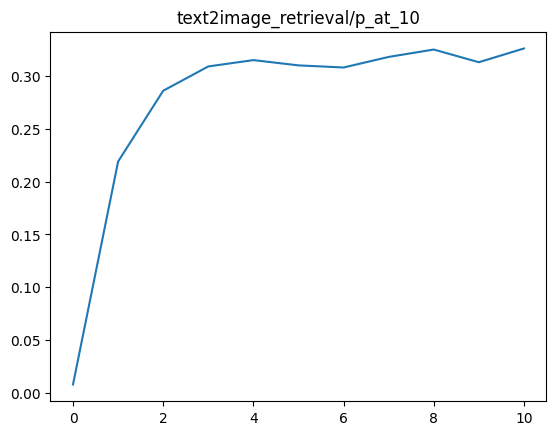

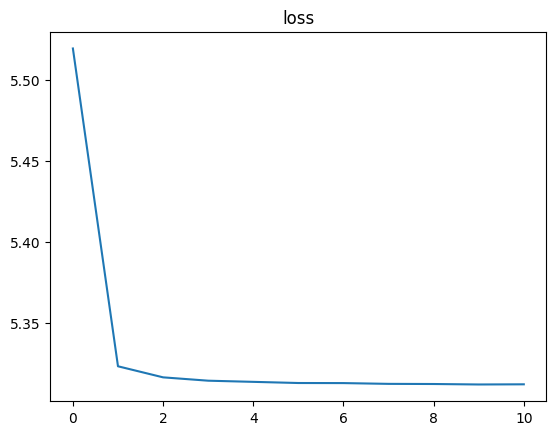

In [13]:
for k in info['metric_values']:
    if k == 'loss':
        print(info['metric_values'][k])
        plt.figure()
        plt.title('loss')
        plt.plot(info['metric_values'][k])
        continue
    for result in info['metric_values'][k]:
        plt.figure()
        plt.title(f'{k}/{result}')
        plt.plot(info['metric_values'][k][result])
plt.show()

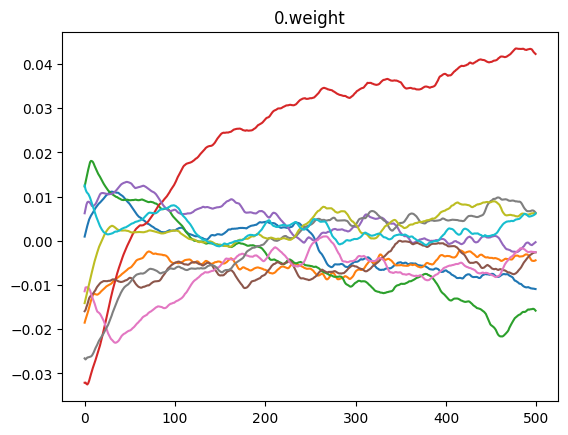

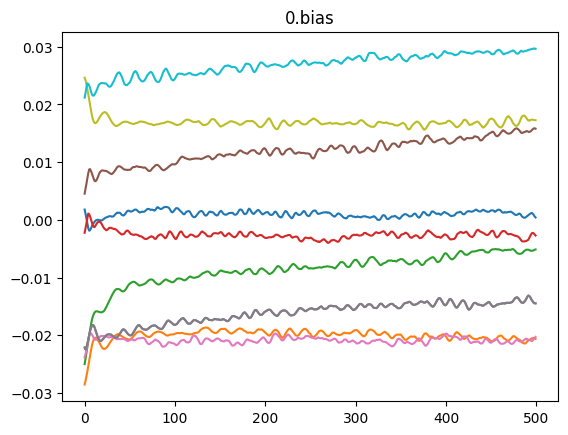

In [14]:
for parameter in info['weights']:
    plt.figure()
    plt.title(parameter)
    plt.plot(info['weights'][parameter])

In [15]:
docs.list_models()

['attribute_predictor',
 'average_glove',
 'clip',
 'clip_projection',
 'clip_text',
 'noun_words',
 'nouns_to_few_hot']

In [ ]:
docs.refresh_model('clip_projection')

In [ ]:
from IPython.display import display

docs.semantic_index = 'simple_image_search'
for r in docs.find({'$like': {'document': {'captions': ['Dog catches frisbee']}, 'n': 5}}):
    display(r['img'])

In [ ]:
from examples.models import NounWords
docs.create_model('noun_words', NounWords(), verbose=True, key='captions')

In [ ]:
docs.create_validation_set('attribute_prediction', sample_size=250)

In [ ]:
import collections
import tqdm
all_nouns = []
for r in tqdm.tqdm(docs.find({'_fold': 'train'}, {'_outputs.captions.noun_words': 1}), total=docs.count_documents({})):
    all_nouns.extend(r['_outputs']['captions']['noun_words'])
    
counts = dict(collections.Counter(all_nouns))
all_nouns = [w for w in counts if counts[w] > 30]
total = docs.count_documents({})
pos_weights = [counts[w] / total for w in all_nouns]

In [ ]:
from examples.models import FewHot, TopK
from examples.metrics import jacquard_index

docs.create_model('nouns_to_few_hot', FewHot(all_nouns))
docs.create_postprocessor('top_5', TopK(all_nouns, 5))
docs.create_forward('attribute_predictor', torch.nn.Linear(1024, len(all_nouns)))
docs.create_loss('nouns_loss', torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weights)))
docs.create_metric('jacquard_index', jacquard_index)

In [ ]:
from examples.models import FewHot
docs.create_model('nouns_to_few_hot', FewHot(post.tokens), active=False,
                 key='_outputs.captions.noun_words')

In [ ]:
docs.create_model('attribute_predictor', forward='attribute_predictor', postprocessor='top_5',
                  key='img', features={'img': 'clip'})

Let's test the model, using the `apply_model` method:

In [10]:
docs.apply_model('attribute_predictor', docs.find_one())

['dishwasher', 'mask', 'containers', 'car', 'stall']

In [12]:
docs.create_imputation(
    'noun_prediction',
    model='attribute_predictor',
    target='nouns_to_few_hot',
    loss='nouns_loss',
    metrics=['jacquard_index'],
    validation_sets=['attribute_prediction'],
    lr=0.001,
    validation_interval=10,
    n_iterations=20,
)

downloading ids for {'_fold': 'train'}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78560/78560 [00:00<00:00, 199309.31it/s]


downloading records for {'_fold': 'valid'}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 3411.61it/s]


fold: VALID; iteration: 0; epoch: 0; attribute_prediction/jacquard_index: 0.0015047619047619048; loss: 0.6905487082725348; 
fold: TRAIN; iteration: 0; epoch: 0; loss: 0.6904535293579102; 
fold: TRAIN; iteration: 1; epoch: 0; loss: 0.6813770532608032; 
fold: TRAIN; iteration: 2; epoch: 0; loss: 0.6711997389793396; 
fold: TRAIN; iteration: 3; epoch: 0; loss: 0.6628069281578064; 
fold: TRAIN; iteration: 4; epoch: 0; loss: 0.6539110541343689; 
fold: TRAIN; iteration: 5; epoch: 0; loss: 0.6436232328414917; 
fold: TRAIN; iteration: 6; epoch: 0; loss: 0.6362203359603882; 
fold: TRAIN; iteration: 7; epoch: 0; loss: 0.6260425448417664; 
fold: TRAIN; iteration: 8; epoch: 0; loss: 0.6195974946022034; 
fold: TRAIN; iteration: 9; epoch: 0; loss: 0.6111948490142822; 
validating model...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 3727.13it/s]


saving
fold: VALID; iteration: 10; epoch: 0; attribute_prediction/jacquard_index: 0.0015047619047619048; loss: 0.6013520692670068; 
fold: TRAIN; iteration: 10; epoch: 0; loss: 0.6021795272827148; 
fold: TRAIN; iteration: 11; epoch: 0; loss: 0.5946300625801086; 
fold: TRAIN; iteration: 12; epoch: 0; loss: 0.5849574208259583; 
fold: TRAIN; iteration: 13; epoch: 0; loss: 0.5744298100471497; 
fold: TRAIN; iteration: 14; epoch: 0; loss: 0.5716163516044617; 
fold: TRAIN; iteration: 15; epoch: 0; loss: 0.5610750913619995; 
fold: TRAIN; iteration: 16; epoch: 0; loss: 0.5524094700813293; 
fold: TRAIN; iteration: 17; epoch: 0; loss: 0.546725869178772; 
fold: TRAIN; iteration: 18; epoch: 0; loss: 0.5377270579338074; 
fold: TRAIN; iteration: 19; epoch: 0; loss: 0.5251182317733765; 
validating model...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 3220.40it/s]


saving
fold: VALID; iteration: 20; epoch: 0; attribute_prediction/jacquard_index: 0.0024047619047619048; loss: 0.5229771178822185; 
computing chunk (1/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 831.59it/s]


bulk writing...
done.
computing chunk (2/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 847.93it/s]


bulk writing...
done.
computing chunk (3/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 839.70it/s]


bulk writing...
done.
computing chunk (4/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 665.87it/s]


bulk writing...
done.
computing chunk (5/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 814.84it/s]


bulk writing...
done.
computing chunk (6/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 873.22it/s]


bulk writing...
done.
computing chunk (7/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 900.53it/s]


bulk writing...
done.
computing chunk (8/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 845.29it/s]


bulk writing...
done.
computing chunk (9/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 833.58it/s]


bulk writing...
done.
computing chunk (10/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 861.05it/s]


bulk writing...
done.
computing chunk (11/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 840.35it/s]


bulk writing...
done.
computing chunk (12/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 874.56it/s]


bulk writing...
done.
computing chunk (13/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 807.13it/s]


bulk writing...
done.
computing chunk (14/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 872.05it/s]


bulk writing...
done.
computing chunk (15/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 852.42it/s]


bulk writing...
done.
computing chunk (16/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 799.62it/s]


bulk writing...
done.
computing chunk (17/17)
finding documents under filter
done.
processing with attribute_predictor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:00<00:00, 846.52it/s]


bulk writing...
done.


We can view the results of learning (metrics, loss etc.) by looking in the `_imputations` subcollection:

In [13]:
docs['_imputations'].find_one()

{'_id': ObjectId('63d9ae67735fd2f6b8df9b44'),
 'name': 'noun_prediction',
 'model': 'attribute_predictor',
 'target': 'nouns_to_few_hot',
 'metrics': ['jacquard_index'],
 'loss': 'nouns_loss',
 'projection': None,
 'filter': None,
 'n_epochs': 20,
 'trainer_kwargs': {'validation_sets': ['attribute_prediction'],
  'lr': 0.001,
  'validation_interval': 10,
  'n_iterations': 20},
 'metric_values': {'attribute_prediction': {'jacquard_index': [0.0015047619047619048,
    0.0015047619047619048,
    0.0024047619047619048]},
  'loss': [0.6905487082725348, 0.6013520692670068, 0.5229771178822185]},
 'weights': {}}

Now we have trained and evaluated several models of various types. This includes multiple interacting models with mutual dependencies. In the case of our own efficient semantic search, and also the attribute predictor, these models are downstream of the image clip model, in the sense that at inference time, clip must be present in order to be able to execute these models. In the case of attribute prediction, the training task was downstream from the 
spacy pipeline for part-of-speech tagging; these tags were used to produce targets for training. However at run-time, the spacy pipeline won't be necessary.

The models which we've added and trained are now ready to go, and when new data is added or updated to the collection, they will automatically process this data, and insert the model outputs into the collection documents.

Here is the complete set of models which exist in the collection:

In [4]:
docs.list_models()

['attribute_predictor',
 'average_glove',
 'clip',
 'clip_projection',
 'clip_text',
 'noun_words',
 'nouns_to_few_hot']

Not all of these respond to incoming data, for that we need to specify the `active` argument:

In [5]:
docs.list_models(active=True)

['attribute_predictor', 'clip', 'clip_projection', 'noun_words']

We can see that these models have processed all documents and their outputs saved:

In [6]:
docs.find_one()

{'_id': ObjectId('63d27372745cc274ef3518f2'),
 'captions': ['A restaurant has modern wooden tables and chairs.',
  'A long restaurant table with rattan rounded back chairs.',
  'a long table with a plant on top of it surrounded with wooden chairs ',
  'A long table with a flower arrangement in the middle for meetings',
  'A table is adorned with wooden chairs with blue accents.'],
 'img': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x168>,
 '_fold': 'train',
 '_outputs': {'img': {'clip': tensor([ 0.0203,  0.0837,  0.0035,  ..., -0.0788,  0.0529, -0.1146]),
   'clip_projection': tensor([ 0.0276,  0.0818, -0.0482, -0.0414,  0.0886, -0.0940,  0.0234, -0.0745,
           -0.1247, -0.0518, -0.0856, -0.0426,  0.0444,  0.0320,  0.0247,  0.0495,
           -0.0079, -0.0169,  0.1407, -0.1423,  0.1019, -0.0112, -0.0730, -0.0060,
           -0.0891,  0.1499, -0.0039,  0.0558, -0.0639,  0.0555,  0.0299, -0.0312,
            0.0298, -0.0540,  0.0155,  0.0800,  0.0311,  0.0915,  0.0415,

Now, let's test what happens when we add new data to the collection, by adding the remaining data points from the 
CoCo data set:

In [ ]:
update = [{**r, "update": True} for r in data[-1000:]]
docs.insert_many(update, verbose=True)